# <center style='color:tan'> Linear Variational AutoEncoder - Example using USPS dataset </center>

## 1. Import the libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

## 2. Define the device

In [3]:
print('PyTorch version:', torch.__version__, '\n')
print('GPU name:', torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device, '\n')
print('Total number of GPUs:', torch.cuda.device_count())

PyTorch version: 2.1.2 

GPU name: NVIDIA GeForce RTX 3060 Laptop GPU 

Device is: cuda 

Total number of GPUs: 1


## 3. Load USPS dataset

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
t = transforms.Compose([
    # transforms.Resize(16),
    transforms.ToTensor()
])
train_dataset = datasets.USPS('./data_src', train=True, download=True, transform=t)
test_dataset = datasets.USPS('./data_src', train=False, download=True, transform=t)

In [6]:
# check the length of training and test datasets

print('Length of the training dataset:', len(train_dataset))
print('Length of the test dataset:', len(test_dataset))

Length of the training dataset: 7291
Length of the test dataset: 2007


#### In total, there are `7291 samples (images)` in the `training set` and `2007 samples (images)` in the `test set`

In [7]:
# check the shape of training and test datasets

print('Shape of the training dataset:', train_dataset.data.shape)
print('Shape of the test dataset:', test_dataset.data.shape)

Shape of the training dataset: (7291, 16, 16)
Shape of the test dataset: (2007, 16, 16)


Shape: (total images, height, width)

#### The `spatial dimension` of the `grayscale images` in the `USPS dataset` is `16x16` pixels

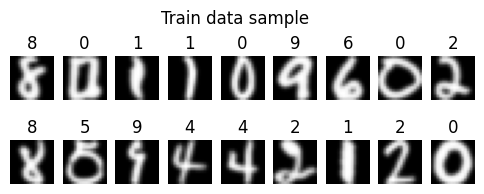

In [8]:
# show 18 randomly selected samples from the training dataset

fig, axis = plt.subplots(nrows=2, ncols=9, figsize=(6, 2))

for ax, _ in zip(axis.ravel(), range(18)):
    inx = np.random.randint(len(train_dataset))
    ax.imshow(train_dataset.data[inx], cmap='Greys_r')
    ax.set_title(train_dataset.targets[inx], fontsize=12)
    ax.axis(False);
plt.suptitle("Train data sample", y=1.05)
plt.show()

## 4. Define dataloaders

In [9]:
batch_size = 32
training_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

In [10]:
# check the length of training and test dataloaders

print(f'Number of batches of size {batch_size} for training dataloader:', len(training_dataloader))
print(f'Number of batches of size {batch_size} for test dataloader:', len(test_dataloader))

Number of batches of size 32 for training dataloader: 227
Number of batches of size 32 for test dataloader: 62


Since, neither 7291 nor 2007 is divisible by 32; the last batch will not have 32 images in it and hence I dropped it. 227 and 62 are showing the number of batches in training and test dataloaders, respectively.

#### Dataloader converts a dataset into an iterable

## 5. Define the network architecture

In [11]:
16*16

256

In [19]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Linear_VAE(nn.Module):
    def __init__(self):
        super(Linear_VAE, self).__init__()
        
        # Encoder
        self.reshape1 = Reshape(-1, 1, 16*16)
        self.linear1 = nn.Linear(in_features=16*16, out_features=128)
        self.linear2 = nn.Linear(in_features=128, out_features=64)
        self.linear3 = nn.Linear(in_features=64, out_features=32)

        self.encoder = nn.Sequential(
            self.reshape1,
            self.linear1,
            nn.ReLU(),
            self.linear2,
            nn.ReLU(),
            self.linear3,
            nn.ReLU(),
        )

        # Between encoder & decoder we calculate latent space
        self.mu = nn.Linear(in_features=32, out_features=2) # Learns to calculate mu
        self.logvar = nn.Linear(in_features=32, out_features=2) # Learns to calculate log(sigma^2)

        # Decoder
        self.linear4 = nn.Linear(in_features=2, out_features=32)
        self.linear5 = nn.Linear(in_features=32, out_features=64)
        self.linear6 = nn.Linear(in_features=64, out_features=128)
        self.linear7 = nn.Linear(in_features=128, out_features=16*16)
        self.reshape2 = Reshape(-1, 1, 16, 16)

        self.decoder = nn.Sequential(
            self.linear4,
            nn.ReLU(),
            self.linear5,
            nn.ReLU(),
            self.linear6,
            nn.ReLU(),
            self.linear7,
            self.reshape2,
        )

        self.activation = nn.Sigmoid()


    def reparameterization(self, mu, logvar):
        # Calculate standard deviation from log(sigma^2)
        # For example, supose sigma = 2
        # we are calculating e^(ln(2*2)/2) = 2
        std = torch.exp(0.5 * logvar)
        # We generate a random normal standard distribution
        eps = torch.rand_like(std)
        # We traslade our N(0,1) distribution with our parameters
        sampling = mu + (eps * std)

        return sampling
    
    def x_to_z(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = self.reparameterization(mu, logvar)

        return z
        
    def forward(self, x):
        # print(f"Input shape: {x.shape = }")
        x = self.encoder(x)
        # print(f"Input shape after decoder: {x.shape = }")
        
        mu = self.mu(x)
        logvar = self.logvar(x)

        # print(f"Mu shape: {mu.shape = }")
        # print(f"Logvar shape: {logvar.shape = }")

        x = self.reparameterization(mu, logvar)
        # print(f"Input shape after reparametrization: {x.shape = }")
        
        x = self.decoder(x)
        # print(f"Input shape after decoder: {x.shape = }")

        x = self.activation(x)
        
        return x, mu, logvar

In `Conv_VAEs`, `Encoder` block outputs two vectors: `mu` and `logvar`. These two vectors are two distributions basically. From these two distributions, latent space is sampled as a __Gaussian distribution__.

## 6. Visualize the model architecture

In [18]:
model = Linear_VAE().to(device)
batch = test_dataset[0][0].unsqueeze(0)
decoded, mu, logvar = model(batch.to(device))
# decoded.shape, mu.shape, logvar.shape

Input shape: x.shape = torch.Size([1, 1, 16, 16])
Input shape after decoder: x.shape = torch.Size([1, 1, 32])
Mu shape: mu.shape = torch.Size([1, 1, 2])
Logvar shape: logvar.shape = torch.Size([1, 1, 2])
Input shape after reparametrization: x.shape = torch.Size([1, 1, 2])
Input shape after decoder: x.shape = torch.Size([1, 1, 16, 16])


In [20]:
model = Linear_VAE().to(device)
summary(model, input_size=(1, 1, 16, 16))

Layer (type:depth-idx)                   Output Shape              Param #
Linear_VAE                               [1, 1, 16, 16]            --
├─Sequential: 1-1                        [1, 1, 32]                --
│    └─Reshape: 2-1                      [1, 1, 256]               --
│    └─Linear: 2-2                       [1, 1, 128]               32,896
│    └─ReLU: 2-3                         [1, 1, 128]               --
│    └─Linear: 2-4                       [1, 1, 64]                8,256
│    └─ReLU: 2-5                         [1, 1, 64]                --
│    └─Linear: 2-6                       [1, 1, 32]                2,080
│    └─ReLU: 2-7                         [1, 1, 32]                --
├─Linear: 1-2                            [1, 1, 2]                 66
├─Linear: 1-3                            [1, 1, 2]                 66
├─Sequential: 1-4                        [1, 1, 16, 16]            --
│    └─Linear: 2-8                       [1, 1, 32]                96
│    

## 7. Define the training batch

In [21]:
def training_batch(data, model, optimizer, loss_function):
    model.train()
    data = data.to(device)
    # print(data.shape)
    recon, mu, logvar = model(data)
    loss = loss_function(recon, data, mu, logvar)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

## 8. Define the test batch

In [22]:
with torch.inference_mode():
    def test_batch(data, model, loss_function):
        model.eval()
        data = data.to(device)
        recon, mu, logvar = model(data)
        loss = loss_function(recon, data, mu, logvar)
        return loss

## 9. Set up model (`VAE`), criterion (`loss function`) and optimizer

In [23]:
def loss_function(recon, x, mu, logvar):
    RECON = F.mse_loss(recon, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return RECON + KLD

In [29]:
linear_vae = Linear_VAE().to(device)
optimizer = optim.Adam(linear_vae.parameters(), lr=0.0005)

## 10. Train the model

In [30]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

n_epochs = 400

training_loss, test_loss = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []
    
    for data, _ in training_dataloader:
        trng_batch_loss = training_batch(data, linear_vae, optimizer, loss_function)
        training_losses.append(trng_batch_loss.item())
    training_per_epoch_loss = np.array(training_losses).mean()
    
    for data, _ in test_dataloader:
        tst_batch_loss = test_batch(data, linear_vae, loss_function)
        test_losses.append(tst_batch_loss.item())
    test_per_epoch_loss = np.array(test_losses).mean()
    
    training_loss.append(training_per_epoch_loss)
    test_loss.append(test_per_epoch_loss)
    
    if (epoch+1) % 20 == 0:
        print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} |   ', end='')
        print(f'Test loss: {test_per_epoch_loss:.4f}')

Epoch: 20/400	| Training loss: 304.3114 |   Test loss: 329.2025
Epoch: 40/400	| Training loss: 284.8439 |   Test loss: 312.8823
Epoch: 60/400	| Training loss: 275.0750 |   Test loss: 304.4687
Epoch: 80/400	| Training loss: 269.5323 |   Test loss: 301.6350
Epoch: 100/400	| Training loss: 265.0063 |   Test loss: 299.1581
Epoch: 120/400	| Training loss: 262.0805 |   Test loss: 293.6388
Epoch: 140/400	| Training loss: 258.8541 |   Test loss: 293.4646
Epoch: 160/400	| Training loss: 257.6678 |   Test loss: 291.9984
Epoch: 180/400	| Training loss: 255.7121 |   Test loss: 289.5607
Epoch: 200/400	| Training loss: 254.9161 |   Test loss: 291.3355
Epoch: 220/400	| Training loss: 253.8347 |   Test loss: 288.8248
Epoch: 240/400	| Training loss: 253.3560 |   Test loss: 288.5527
Epoch: 260/400	| Training loss: 252.4119 |   Test loss: 285.6965
Epoch: 280/400	| Training loss: 251.8885 |   Test loss: 287.6145
Epoch: 300/400	| Training loss: 251.1111 |   Test loss: 290.4586
Epoch: 320/400	| Training los

I trained the `Conv_VAE` model for `100 epochs` only. However, you can obviously train it for a longer period of time and observe if the performance gets better or not! 

In [51]:
torch.save(linear_vae.state_dict(), "linear_vae_usps.pt")

## 11. Plot model loss

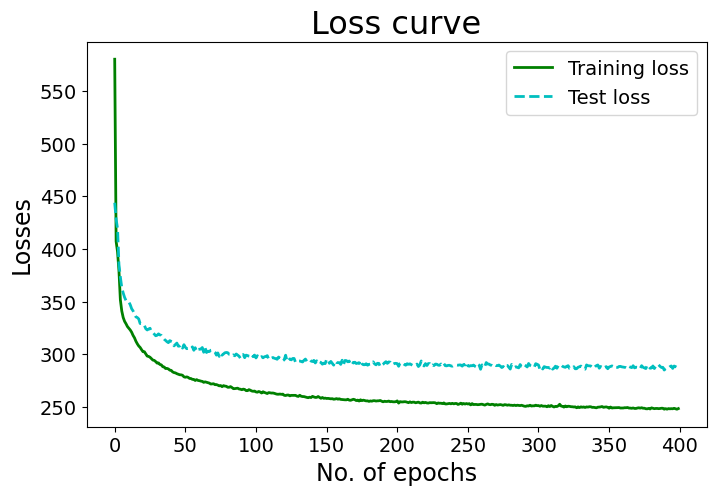

In [32]:
plt.figure(figsize=(8, 5))

plt.plot(training_loss, 'g-', linewidth=2, label='Training loss')
plt.plot(test_loss, 'c--', linewidth=2, label='Test loss')
plt.title('Loss curve', fontsize=23)
plt.xlabel('No. of epochs', fontsize=17)
plt.ylabel('Losses', fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14);

## 12. Model prediction

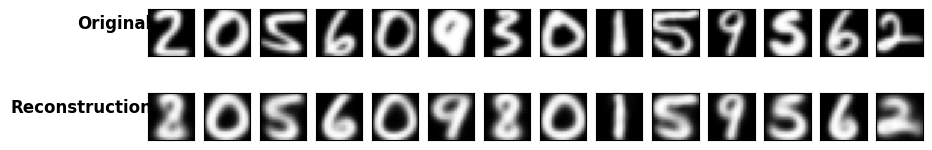

In [33]:
ORG, REC = [], []

for a in range(14):
    idx = np.random.randint(len(test_dataset))
    ORG.append(test_dataset[idx][0])
    REC.append(linear_vae.cpu()(ORG[a].unsqueeze(0))[0])
    
fig, ax = plt.subplots(nrows=2, ncols=14, figsize=(10, 2))

for i in range(14):
    ax[0, i].imshow(ORG[i].squeeze(), cmap='Greys_r')
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
    ax[1, i].imshow(REC[i].squeeze().cpu().detach().numpy(), cmap='Greys_r')
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])

ax[0, 0].set_ylabel('Original', fontsize=12, rotation=0, labelpad=24, fontweight='bold')
ax[1, 0].set_ylabel('Reconstruction', fontsize=12, rotation=0, labelpad=48, fontweight='bold');

We randomly selected 14 images from the test set and checked the corresponding `reconstruction` provided by the `Conv_VAE` model.

It's very difficult to understand but if you closely look, you can notice that the reconstructed images are much better in this case compared to what we got using `VAE` model in the previous video. Nevertheless, there are fine differences between the original and reconstructed images. Moreover, The sixth and seventh reconstructed images in the above picture don't look very similar to their original equivalents.

## 13. Create samples from noise vectors

In [34]:
linear_vae.decoder

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=256, bias=True)
  (7): Reshape()
)

The size of the `input_vector` to the decoder will have to be: `(16, 1, 1)` ===> `(C, H, W)`.

In [35]:
linear_vae.decoder

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=256, bias=True)
  (7): Reshape()
)

In [36]:
with torch.inference_mode():
    noise_vecs = torch.randn(180, 2)
    print(noise_vecs.shape)
    sampled = linear_vae.decoder(noise_vecs)
    print(sampled.shape)
    gen_imgs = make_grid(sampled, nrow=18).permute(1, 2, 0)

torch.Size([180, 2])
torch.Size([180, 1, 16, 16])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


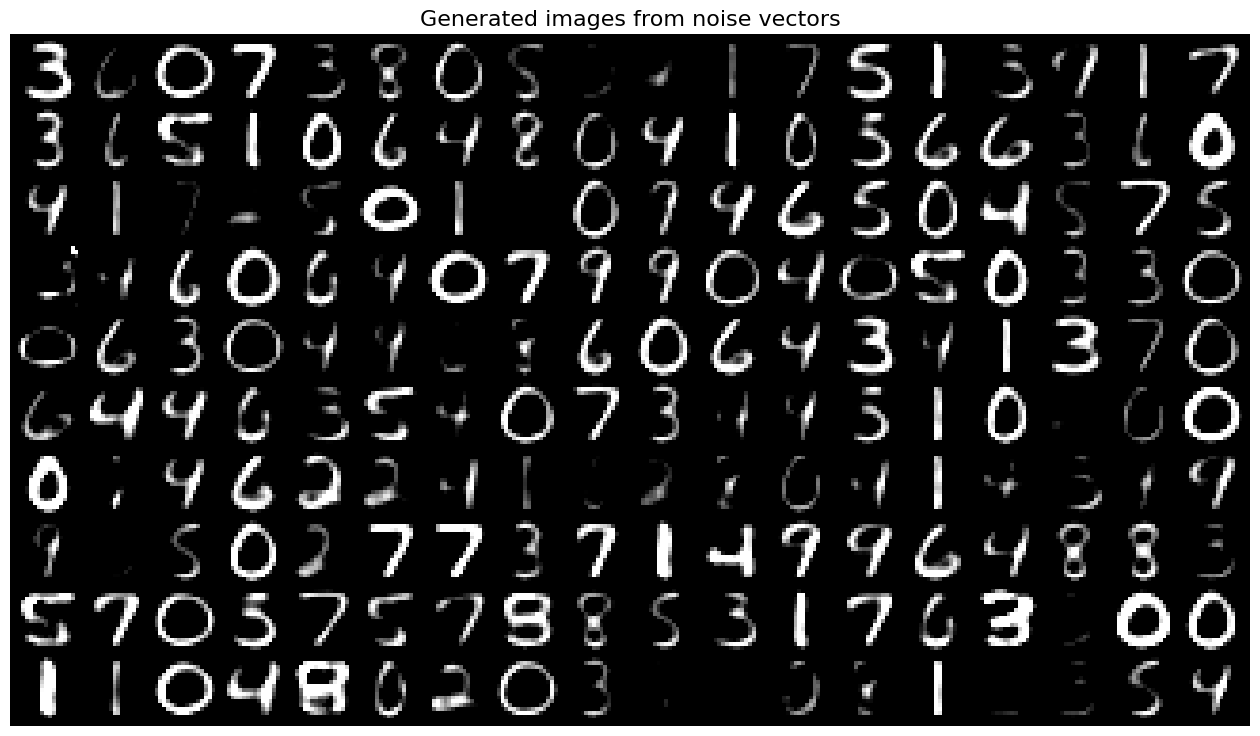

In [37]:
plt.figure(figsize=(16, 10))
plt.imshow(gen_imgs, cmap='Greys_r')
plt.title('Generated images from noise vectors', fontsize=16)
plt.axis(False);

We generated 180 images from noise vectors. They simply don't look good after 100 epochs. So, the model needs to be trained for higher number of epochs.

In [38]:
x_train = []
y_train = []
labels = []

for batch in train_dataset:
    images, labs = batch
    images = images.unsqueeze(0)
    # print(images.shape, labs)
    # print(f"Input shape: {x.shape = }")
    z = linear_vae.x_to_z(images) # Encodes and reparameterize
    # print(z.shape)

    x_train.append(z[:,0,0].detach().item())
    y_train.append(z[:,0,1].detach().item())
    labels.append(labs)

    # print(x, y)

x_test = []
y_test = []
labels_test = []

for batch in test_dataset:
    images, labs = batch
    images = images.unsqueeze(0)
    # print(images.shape, labs)
    # print(f"Input shape: {x.shape = }")
    z = linear_vae.x_to_z(images) # Encodes and reparameterize
    # print(z.shape)

    x_test.append(z[:,0,0].detach().item())
    y_test.append(z[:,0,1].detach().item())
    labels_test.append(labs)

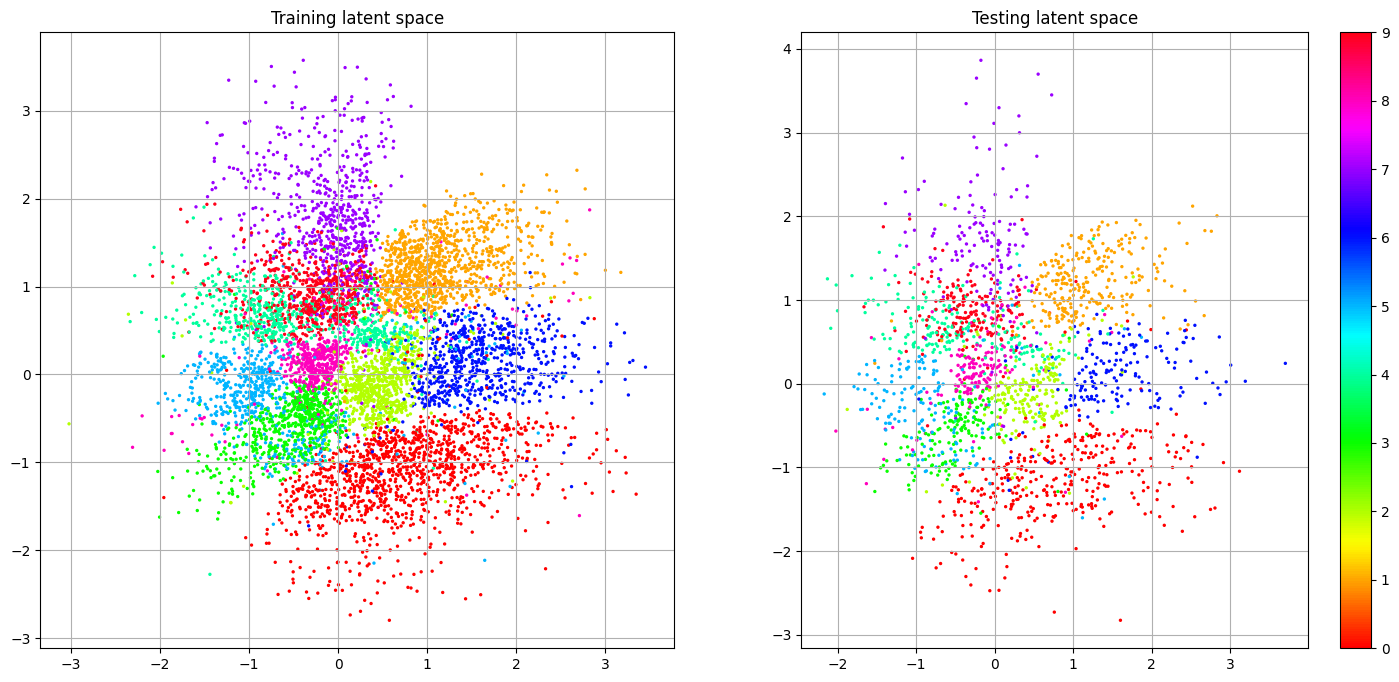

In [39]:
plt.figure(figsize=(18, 8))
plt.subplot(1,2,1)
plt.scatter(x_train, y_train, s=2, c=labels, cmap='hsv')
# plt.colorbar()
plt.grid()
plt.title("Training latent space")
plt.subplot(1,2,2)
plt.scatter(x_test, y_test, s=2, c=labels_test, cmap='hsv')
plt.colorbar()
plt.grid()
plt.title("Testing latent space")
# plt.legend()
plt.show()

torch.Size([1, 1, 2])
torch.Size([1, 1, 16, 16])


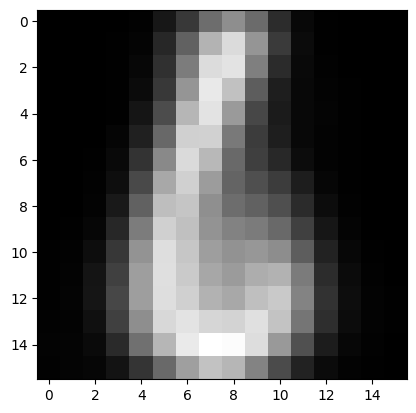

In [48]:
z1, z2 = 1.5, 0.65
input = torch.tensor([[[z1, z2]]], dtype=torch.float)
print(input.shape)
decoded_example = linear_vae.decoder(input)
decoded_example = linear_vae.activation(decoded_example)
print(decoded_example.shape)
plt.imshow(decoded_example[0, 0].detach().cpu().numpy(), cmap="gray")

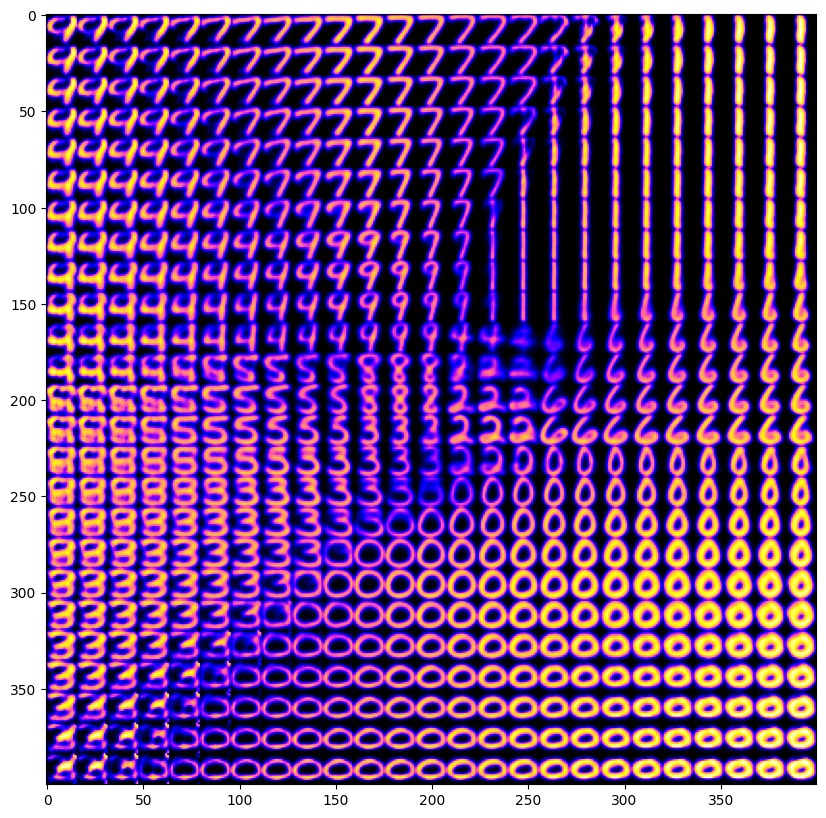

In [50]:
n = 25  # generate 15x15 digits
figure = np.zeros((16 * n, 16 * n, 1))

#Create a Grid of latent variables, to be provided as inputs to decoder.predict
#Creating vectors within range -5 to 5 as that seems to be the range in latent space
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)[::-1]

# decoder for each square in the grid
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])

        z_sample = torch.tensor([[xi, yi]], dtype=torch.float)
        x_decoded = linear_vae.decoder(z_sample)
        x_decoded = linear_vae.activation(x_decoded).detach().cpu()
        x_decoded = x_decoded.squeeze(0).permute(1,2,0).numpy()

        figure[i * 16: (i + 1) * 16,
               j * 16: (j + 1) * 16] = x_decoded

plt.figure(figsize=(10, 10))
#Reshape for visualization
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))

plt.imshow(figure, cmap='gnuplot2')
plt.show()  